In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
from re import I
from stat import UF_OPAQUE
from tqdm import tqdm
import math

import torch
from torch.utils.data import DataLoader
from code.dataset.dtu_train import MVSDataset
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.utilities.model_summary import ModelSummary
from copy import deepcopy
from code.model import VolRecon
from code.dataset.dtu_test_sparse import DtuFitSparse
from code.dataset.general_fit import GeneralFit
import numpy as np
import torch
from torch import nn
from einops import rearrange, reduce, repeat
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from code.utils.grid_sample import grid_sample_2d
from code.utils.cnn3d import VolumeRegularization


PI = math.pi
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import matplotlib.pyplot as plt


def visualize_depth_maps(depth_maps_resized):
    """
    Visualize each depth map in depth_maps_resized.

    Args:
    depth_maps_resized (torch.Tensor): A tensor of depth maps with shape [B, NV, H, W].
    """
    B, NV, H, W = depth_maps_resized.shape

    # Create a subplot for each depth map
    fig, axs = plt.subplots(B, NV, figsize=(NV * 3, B * 3))

    for b in range(B):
        for nv in range(NV):
            ax = axs[b, nv] if B > 1 else axs[nv]
            depth_map = depth_maps_resized[b, nv].cpu().numpy()
            im = ax.imshow(
                depth_map, cmap="viridis"
            )  # You can choose different colormaps like 'gray', 'plasma', etc.

            ax.set_title(f"Batch {b}, View {nv}")
            ax.axis("off")

    # Add a color bar
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)

    plt.show()

In [4]:
dtu_dataset_train = MVSDataset(
    root_dir="/home/dataset/mvs_training/dtu/",
    split="train",
    split_filepath="code/dataset/dtu/lists/train.txt",
    pair_filepath="code/dataset/dtu/dtu_pairs.txt",
    n_views=5,
)
print("dtu_dataset_train:", len(dtu_dataset_train))

dataloader_train = DataLoader(
    dtu_dataset_train, batch_size=2, num_workers=0, shuffle=False
)

loading all scenes together
dtu_dataset_train: 24150


In [5]:
def get_batch_by_index(dataloader, batch_index):
    for i, batch in enumerate(dataloader):
        if i == batch_index:
            return batch
    raise IndexError("Batch index out of range")


# Example usage
batch = get_batch_by_index(dataloader_train, 3)  # Get 4th batch (indexing starts at 0)

In [8]:
class DummyArgs:
    def __init__(self):
        self.weight_rgb=1.0
        self.weight_depth=1.0 
        self.train_ray_num=512 #1024
        self.volume_reso=48 # 96
        self.extract_geometry=False
        self.lr=0.1
        self.coarse_sample=64
        self.fine_sample=64
        self.concat_tsdf_vol=False

# load_ckpt="/home/umair/VolReconWithDepthPriors/checkpoints/epoch=15-step=193199.ckpt"
load_ckpt="checkpoints/tsdf_lite_baseline/epoch=15-step=193200.ckpt"
volrecon = VolRecon.load_from_checkpoint(checkpoint_path=load_ckpt, args=DummyArgs())

In [9]:
feat_vol_weights = volrecon.feature_volume.state_dict()

### FineRecon

In [10]:
## Creating DG feature volume

def sample_voxel_feats(img_feats, poses, K, xyz, imsize, invalid_fill_value=0):
    base_imheight, base_imwidth = imsize
    featheight = img_feats.shape[3]
    featwidth = img_feats.shape[4]
    _K = K.clone()
    _K[:, :, 0] *= featwidth / base_imwidth
    _K[:, :, 1] *= featheight / base_imheight

    voxel_feats, valid = sample_posed_images(
        img_feats,
        poses,
        _K,
        xyz,
        mode="bilinear",
        padding_mode="border",
    )
    voxel_feats.masked_fill_(~valid[:, :, None], invalid_fill_value)

    return voxel_feats, valid

def get_img_voxel_feats_by_img_bp(
    rgb_imgs,
    poses,
    K_color,
    input_coords,
    use_highres_cnn=False,
    img_feats=None,
):
    batch_size, n_imgs, _, imheight, imwidth = rgb_imgs.shape
    imsize = (imheight, imwidth)

    img_feats = img_feats.view(batch_size, n_imgs, *img_feats.shape[1:])

    img_voxel_feats, img_voxel_valid = sample_voxel_feats(
        img_feats, poses, K_color, input_coords, imsize
    )

    if (not self.training) and use_highres_cnn:
        # down-weight the high-res BP image features near the image border
        # to reduce boundary artifacts.
        # works at inference time, not tested with training

        xyz = input_coords
        batch_size = xyz.shape[0]
        xyz = xyz.view(batch_size, 1, -1, 3).transpose(3, 2)
        xyz = torch.cat((xyz, torch.ones_like(xyz[:, :, :1])), dim=2)

        featheight, featwidth = img_feats.shape[-2:]

        K = K_color.clone()
        K[:, :, 0] *= featwidth / imwidth
        K[:, :, 1] *= featheight / imheight
        with torch.autocast(enabled=False, device_type=self.device.type):
            xyz_cam = (torch.inverse(poses) @ xyz)[:, :, :3]
            uv = K @ xyz_cam
        uv = uv[:, :, :2] / uv[:, :, 2:]

        featsize = torch.tensor(
            [featwidth, featheight], device=self.device, dtype=uv.dtype
        )[None, None, :, None]
        uv[:, :, 0].clamp_(0, imwidth)
        uv[:, :, 1].clamp_(0, imheight)
        border_dist = ((uv / featsize).round() * featsize - uv).abs().min(dim=2)[0]
        pixel_margin = 20
        weight = (border_dist / pixel_margin).clamp(0, 1)
        weight = torch.sigmoid(weight * 12 - 6)
        img_voxel_feats *= weight[:, :, None]

    return img_voxel_feats, img_voxel_valid


def get_img_voxel_feats_by_depth_guided_bp(
    rgb_imgs,
    pred_depth_imgs,
    poses,
    K_color,
    K_pred_depth,
    input_coords,
    use_highres_cnn=False,
    img_feats=None,
):
    img_voxel_feats, img_voxel_valid = get_img_voxel_feats_by_img_bp(
        rgb_imgs,
        poses,
        K_color,
        input_coords,
        use_highres_cnn=use_highres_cnn,
        img_feats=img_feats,
    )

    depth, depth_valid, z = sample_posed_images(
        pred_depth_imgs[:, :, None],
        poses,
        K_pred_depth,
        input_coords,
        mode="nearest",
        return_z=True,
    )
    depth = depth.squeeze(2)

    depth_valid.masked_fill_(depth == 0, False)

    img_voxel_feats.masked_fill_(~img_voxel_valid[:, :, None], 0)

    return img_voxel_feats, img_voxel_valid

In [11]:
### Creating V_d --> TSDF Volume
def project(xyz, poses, K, imsize):
    """
    xyz: b x (*spatial_dims) x 3
    poses: b x nviews x 4 x 4
    K: (b x nviews x 3 x 3)
    imsize: (imheight, imwidth)
    """

    device = xyz.device
    batch_size = xyz.shape[0]
    spatial_dims = xyz.shape[1:-1]
    n_views = poses.shape[1]

    xyz = xyz.view(batch_size, 1, -1, 3).transpose(3, 2)
    xyz = torch.cat((xyz, torch.ones_like(xyz[:, :, :1])), dim=2)

    with torch.autocast(enabled=False, device_type=device.type):
        xyz_cam = (torch.inverse(poses) @ xyz)[:, :, :3]
        uv = K @ xyz_cam

    z = uv[:, :, 2]
    uv = uv[:, :, :2] / uv[:, :, 2:]
    imheight, imwidth = imsize
    """
    assuming that these uv coordinates have
        (0, 0) = center of top left pixel
        (w - 1, h - 1) = center of bottom right pixel
    then we allow values between (-.5, w-.5) because they are inside the border pixel
    """
    valid = (
        (uv[:, :, 0] >= -0.5)
        & (uv[:, :, 1] >= -0.5)
        & (uv[:, :, 0] <= imwidth - 0.5)
        & (uv[:, :, 1] <= imheight - 0.5)
        & (z > 0)
    )
    uv = uv.transpose(2, 3)
    uv = uv.view(batch_size, n_views, *spatial_dims, 2)
    z = z.view(batch_size, n_views, *spatial_dims)
    valid = valid.view(batch_size, n_views, *spatial_dims)
    return uv, z, valid


def sample_posed_images(
    imgs, poses, K, xyz, mode="bilinear", padding_mode="zeros", return_z=False
):
    """
    imgs: b x nviews x C x H x W
    poses: b x nviews x 4 x 4
    K: (b x nviews x 3 x 3)
    xyz: b x (*spatial_dims) x 3
    """

    device = imgs.device
    batch_size, n_views, _, imheight, imwidth = imgs.shape
    spatial_dims = xyz.shape[1:-1]

    """
    assuming that these uv coordinates have
        (0, 0) = center of top left pixel
        (w - 1, h - 1) = center of bottom right pixel

    adjust because grid_sample(align_corners=False) assumes
        (0, 0) = top left corner of top left pixel
        (w, h) = bottom right corner of bottom right pixel
    """
    uv, z, valid = project(xyz, poses, K, (imheight, imwidth))
    imsize = torch.tensor([imwidth, imheight], device=device)
    # grid = (uv + 0.5) / imsize * 2 - 1
    grid = uv / (0.5 * imsize) + (1 / imsize - 1)
    vals = torch.nn.functional.grid_sample(
        imgs.view(batch_size * n_views, *imgs.shape[2:]),
        grid.view(batch_size * n_views, 1, -1, 2),
        align_corners=False,
        mode=mode,
        padding_mode=padding_mode,
    )
    vals = vals.view(batch_size, n_views, -1, *spatial_dims)
    if return_z:
        return vals, valid, z
    else:
        return vals, valid


def tsdf_fusion(pred_depth_imgs, poses, K_pred_depth, input_coords):
    depth, valid, z = sample_posed_images(
        pred_depth_imgs[:, :, None],
        poses,
        K_pred_depth,
        input_coords,
        mode="nearest",
        return_z=True,
    )
    depth = depth.squeeze(2)
    valid.masked_fill_(depth == 0, False)
    margin = 3 * 1  # self.config.voxel_size
    tsdf = torch.clamp(z - depth, -margin, margin) / margin
    valid &= tsdf < 0.999
    tsdf.masked_fill_(~valid, 0)
    tsdf = torch.sum(tsdf, dim=1)
    weight = torch.sum(valid, dim=1)
    tsdf /= weight
    return tsdf, weight

In [12]:
batch.keys()

dict_keys(['images', 'w2cs', 'c2ws', 'near_fars', 'intrinsics', 'meta', 'scale_mat', 'trans_mat', 'ref_img', 'source_imgs', 'ref_pose', 'source_poses', 'ref_pose_inv', 'source_poses_inv', 'ray_o', 'ray_d', 'cam_ray_d', 'depths_h', 'depths_prior_h'])

In [13]:
volume_reso = DummyArgs().volume_reso
x_line = (np.linspace(0, volume_reso - 1, volume_reso)) * 2 / (
    volume_reso - 1
) - 1  # [-1, 1]
y_line = (np.linspace(0, volume_reso - 1, volume_reso)) * 2 / (volume_reso - 1) - 1
z_line = (np.linspace(0, volume_reso - 1, volume_reso)) * 2 / (volume_reso - 1) - 1

# create the volume grid
x, y, z = np.meshgrid(x_line, y_line, z_line, indexing="ij")
xyz = np.stack([x, y, z])
xyz = np.transpose(xyz, (1, 2, 3, 0))
xyz = torch.tensor(xyz).unsqueeze(0)

## Batchify the volume grid
B, NV, _, _ = batch["intrinsics"].shape
xyz = torch.stack([xyz] * B, axis=0)
xyz = xyz.reshape(B, -1, 3)

## ScanNet: https://github.com/ScanNet/ScanNet/issues/24#issuecomment-514077850
# FineRecon uses ScanNet which stores poses (cam2world) not extrinsics (world2cam)
## FineRecon project uses these poses

tsdf, weight = tsdf_fusion(
    batch["depths_h"][:, 1:].float().cuda(),
    batch["c2ws"][:, 1:].cuda(),
    batch["intrinsics"][:, 1:].cuda(),
    xyz.type_as(batch["intrinsics"]).cuda(),
)
tsdf.masked_fill_(weight == 0, 1)
# voxel_feats = torch.cat((voxel_feats, tsdf[:, None]), dim=1) ## Concatenation

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

##### Verify TSDF Output

In [14]:
# Reshape into a 3D tensor
tsdf_volume = tsdf.reshape(B, volume_reso, volume_reso, volume_reso)

In [15]:
## Batch index to inspect
bidx = 0

In [16]:
## Ensure not all 1s
print(f"Mean: {torch.mean(tsdf_volume)}, Std Dev: {torch.std(tsdf_volume)}")
torch.max(tsdf_volume[bidx]), torch.min(tsdf_volume[bidx])

Mean: 0.8158097267150879, Std Dev: 0.36232346296310425


(tensor(1., device='cuda:0'), tensor(-0.4926, device='cuda:0'))

In [17]:
weight_volume = weight.reshape(B, volume_reso, volume_reso, volume_reso).float()
print(f"Mean: {torch.mean(weight_volume)}, Std Dev: {torch.std(weight_volume)}")
torch.max(weight_volume[bidx]), torch.min(weight_volume[bidx])

Mean: 0.5493977665901184, Std Dev: 1.1891887187957764


(tensor(4., device='cuda:0'), tensor(0., device='cuda:0'))

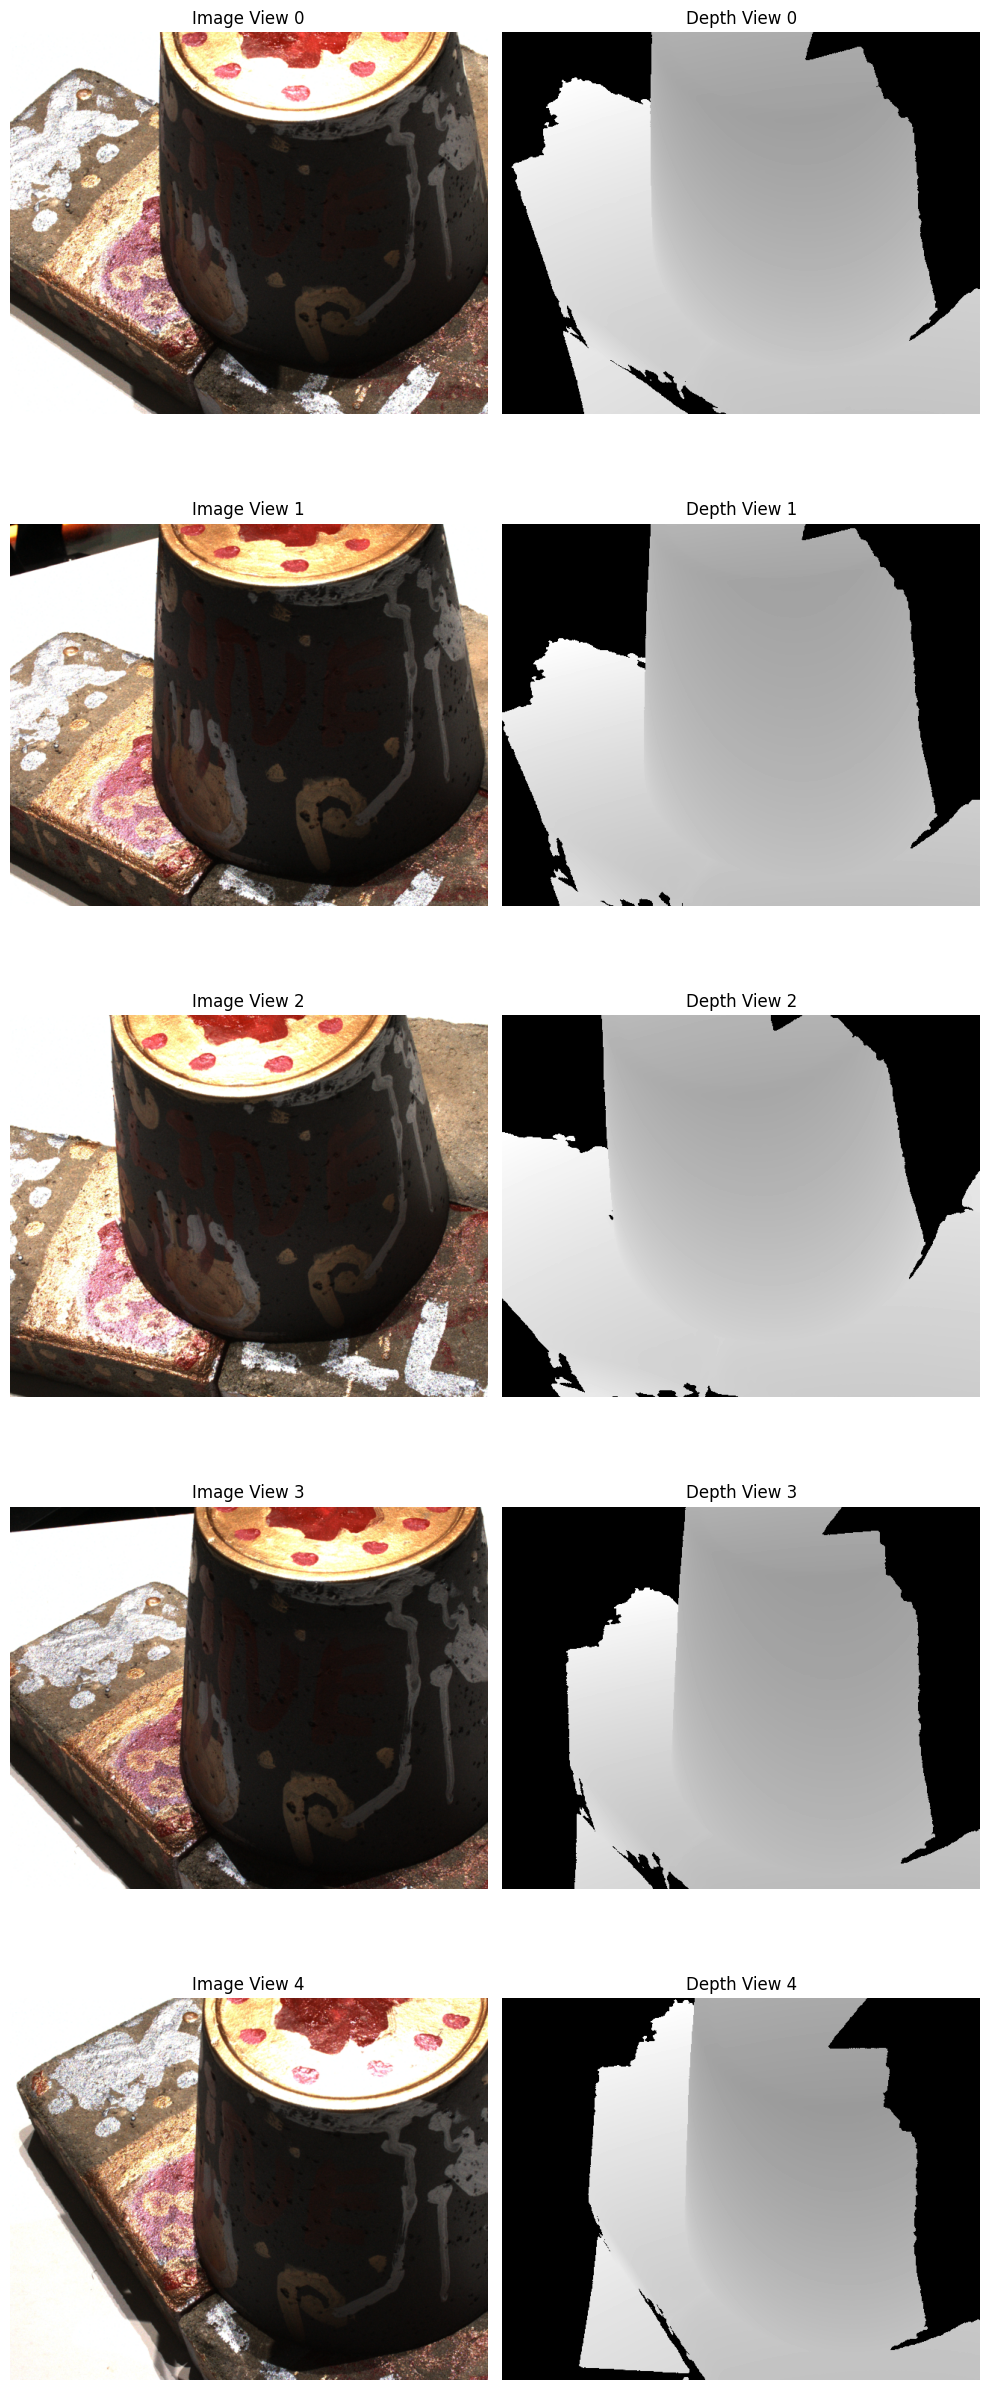

In [18]:
def visualize_batch(data, batch_index):
    """
    Visualizes images and corresponding depth maps for a given batch index.

    Args:
    - data (dict): Dictionary containing the batched data.
    - batch_index (int): The index of the batch to visualize.
    """
    images = data["images"][batch_index]  # Shape: [num_views, c, h, w]
    depths = data["depths_h"][batch_index]  # Shape: [num_views, h, w]
    num_views, _, _ = depths.shape

    fig, axs = plt.subplots(num_views, 2, figsize=(10, 5 * num_views))

    for i in range(num_views):
        img = (
            images[i].permute(1, 2, 0).cpu().numpy()
        )  # Convert to [h, w, c] for plotting
        depth = depths[i].cpu().numpy()

        if num_views > 1:
            ax_img = axs[i, 0]
            ax_depth = axs[i, 1]
        else:
            ax_img = axs[0]
            ax_depth = axs[1]

        ax_img.imshow(img)
        ax_img.set_title(f"Image View {i}")
        ax_img.axis("off")

        ax_depth.imshow(depth, cmap="gray")
        ax_depth.set_title(f"Depth View {i}")
        ax_depth.axis("off")

    plt.tight_layout()
    plt.show()

visualize_batch(batch, batch_index=bidx)

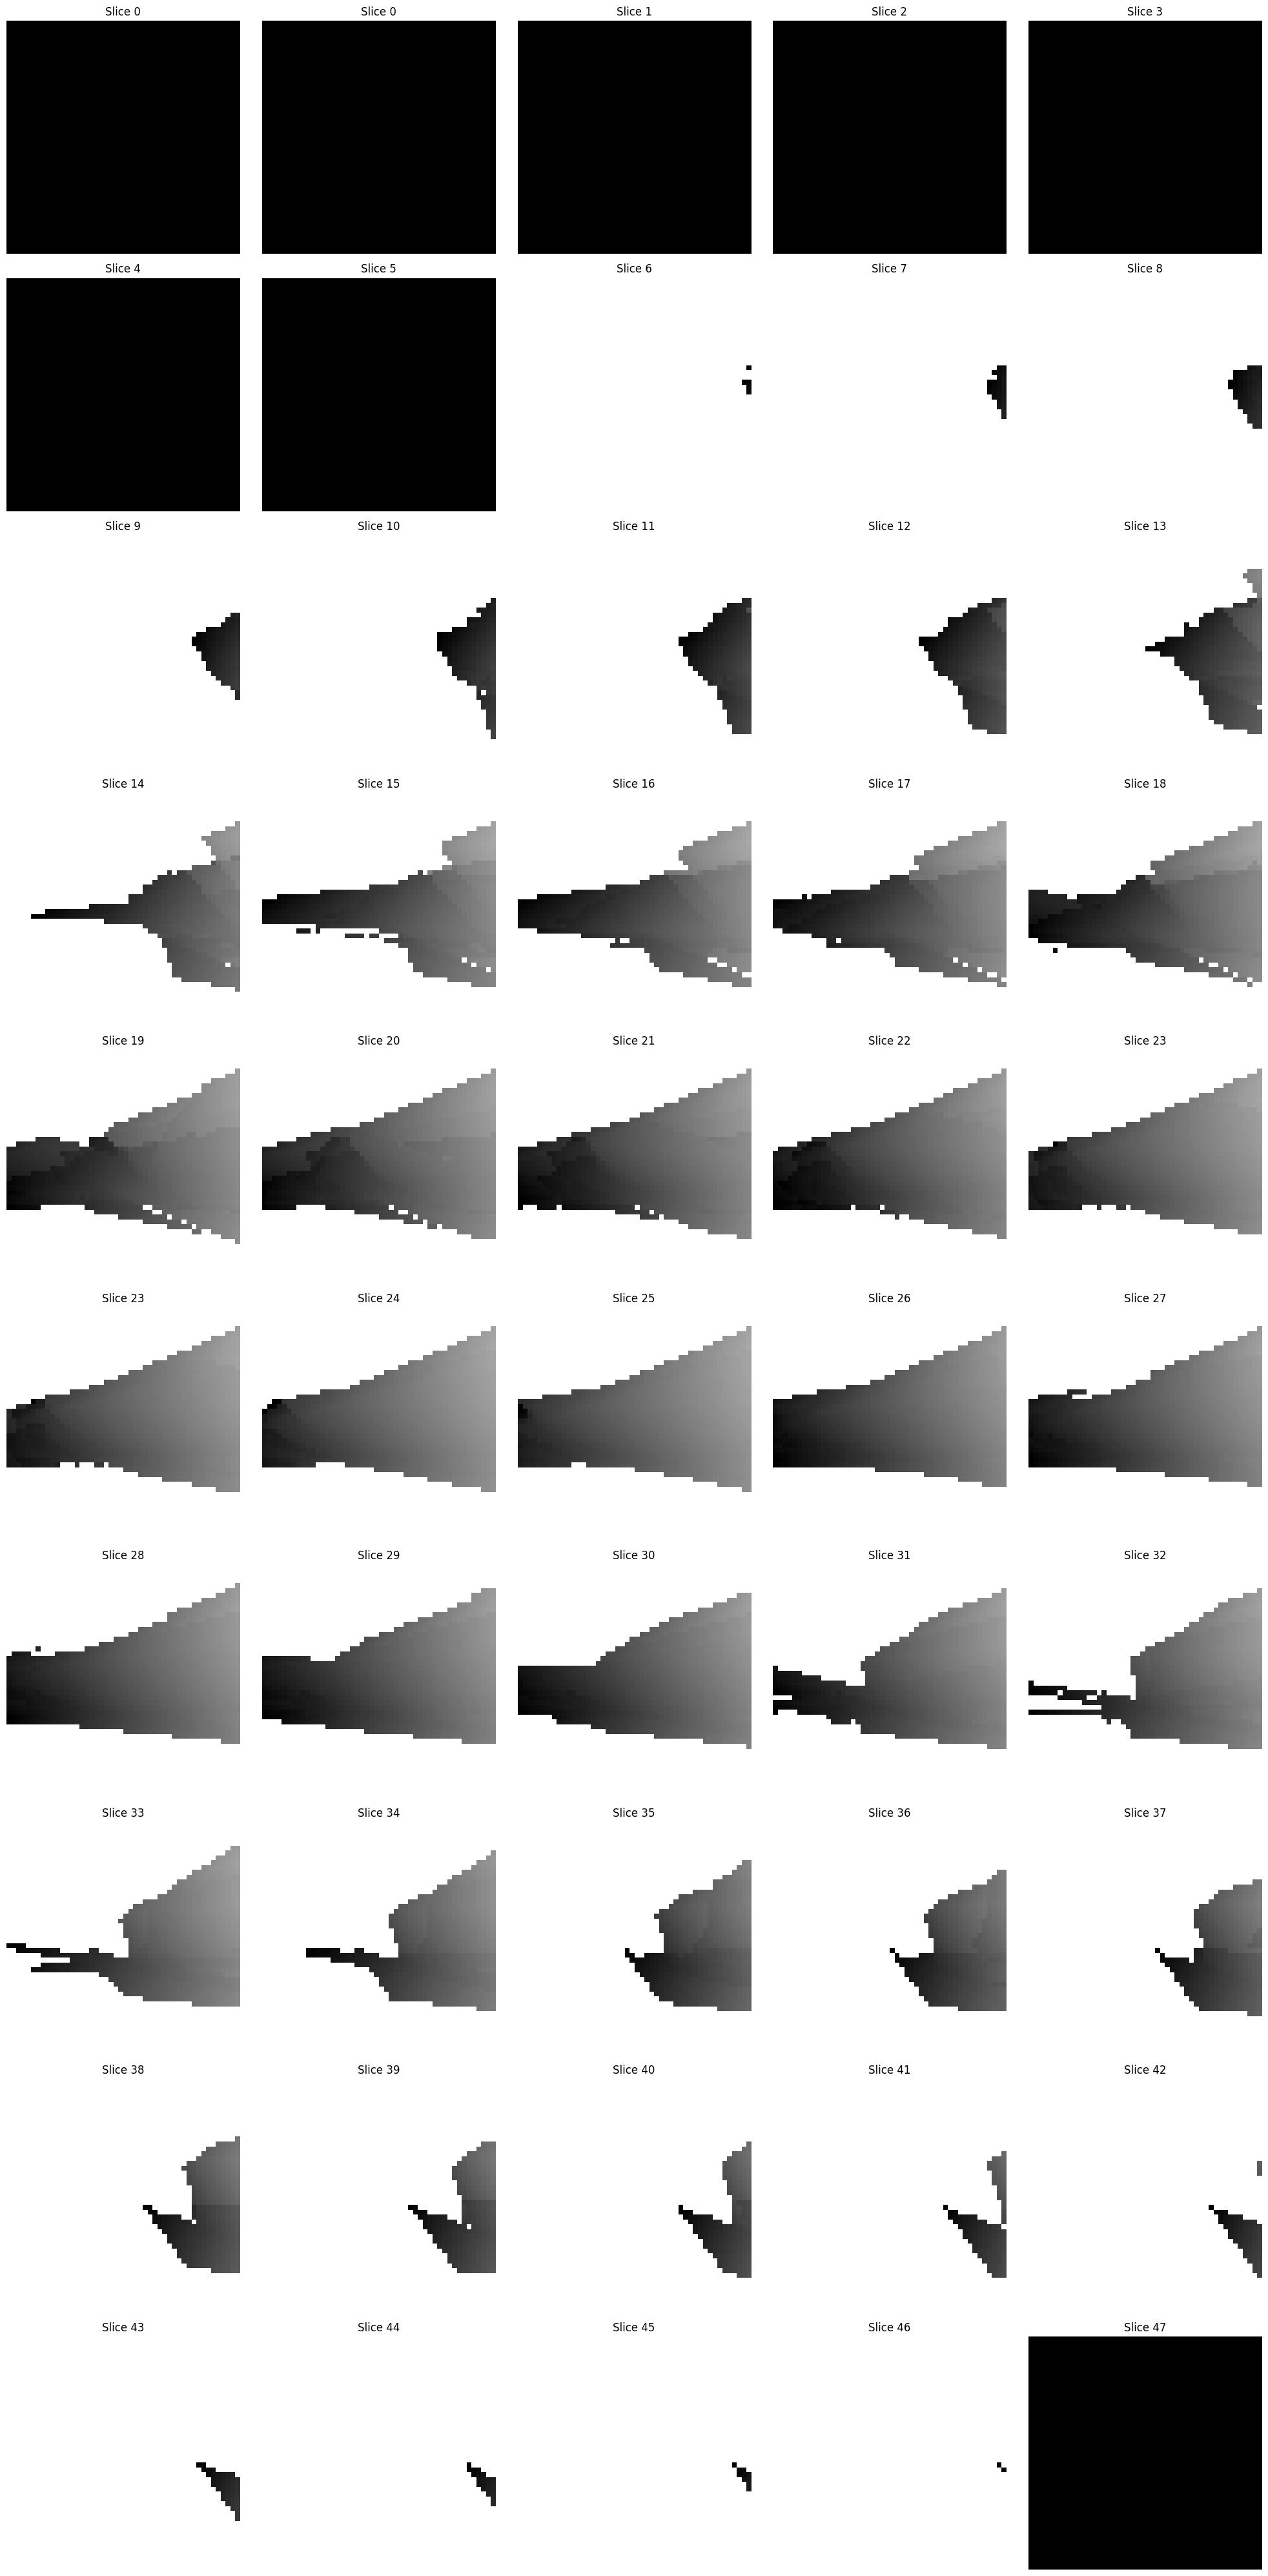

In [19]:
def plot_tsdf_volume(tsdf_volume, axis=0, slice_count=10, max_columns=5):
    """
    Plots slices of a 3D TSDF volume in a grid layout with a limited number of columns.

    Args:
    - tsdf_volume (torch.Tensor): A 3D tensor representing the TSDF volume.
    - axis (int): The axis along which to take slices (0, 1, or 2).
    - slice_count (int): The number of slices to plot.
    - max_columns (int): The maximum number of columns in the plot grid.
    """
    if not isinstance(tsdf_volume, torch.Tensor) or tsdf_volume.ndim != 3:
        raise ValueError("tsdf_volume must be a 3D torch.Tensor")

    # Compute the indices of the slices to plot
    indices = torch.linspace(0, tsdf_volume.shape[axis] - 1, slice_count).int()

    # Calculate the number of rows and columns for the subplot grid
    rows = slice_count // max_columns + int(slice_count % max_columns > 0)
    cols = min(slice_count, max_columns)

    # Set up the plot
    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows * cols > 1:
        axs = axs.ravel()

    # Plot each slice
    for i, idx in enumerate(indices):
        if axis == 0:
            slice_ = tsdf_volume[idx, :, :]
        elif axis == 1:
            slice_ = tsdf_volume[:, idx, :]
        else:  # axis == 2
            slice_ = tsdf_volume[:, :, idx]

        if rows * cols > 1:
            ax = axs[i]
        else:
            ax = axs

        ax.imshow(slice_.cpu().numpy(), cmap="gray")
        ax.set_title(f"Slice {idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize "Slices" of the TSDF volume in 2d
plot_tsdf_volume(tsdf_volume[bidx], axis=0, slice_count=50, max_columns=5)

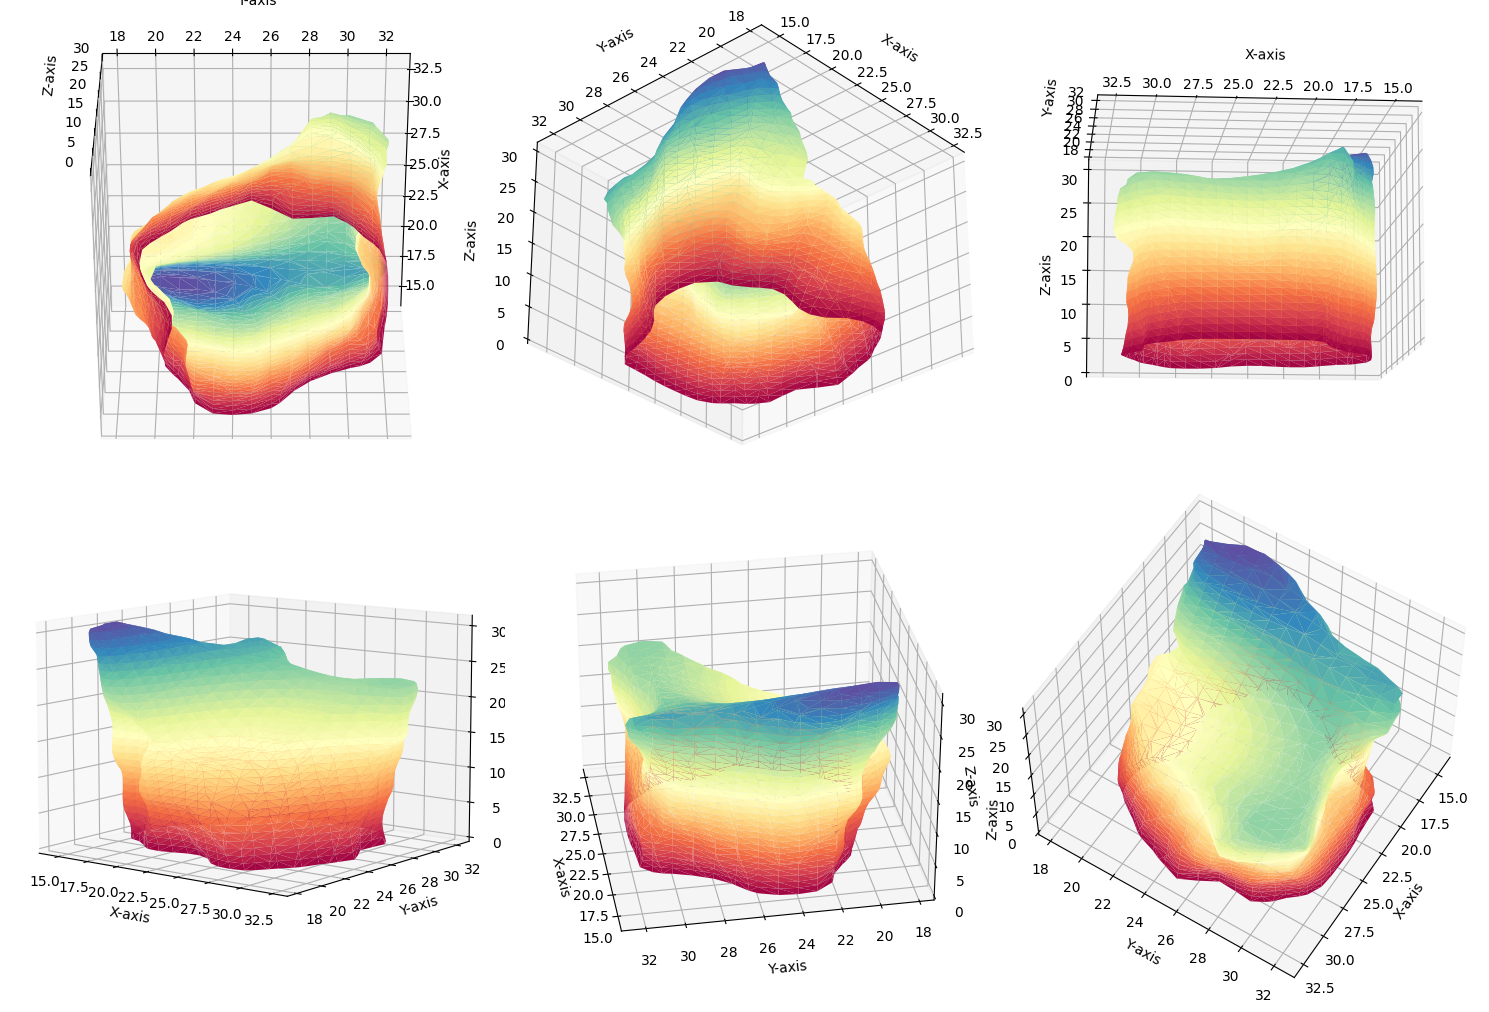

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from skimage.measure import marching_cubes_lewiner
import math


def generate_views(N):
    """
    Generates N views distributed evenly over a sphere.

    Args:
    - N (int): The number of views to generate.

    Returns:
    - List of tuples representing (elevation, azimuth) for each view.
    """
    views = []
    for i in range(N):
        # Generate evenly distributed points on a sphere using the golden angle
        phi = math.acos(1 - 2 * (i + 0.5) / N)
        theta = math.pi * (1 + 5**0.5) * i

        elevation = np.rad2deg(phi) - 90
        azimuth = np.rad2deg(theta)
        views.append((elevation, azimuth))

    return views


def plot_tsdf_isosurface(tsdf_volume, N, level=0, smoothing_sigma=1):
    """
    Plots the isosurface from a 3D TSDF volume using the marching cubes lewiner algorithm.
    Renders the object in N dynamically generated views.

    Args:
    - tsdf_volume (numpy.ndarray): A 3D numpy array representing the TSDF volume.
    - N (int): The number of views to generate.
    - level (float): The level at which to create the isosurface (default is 0).
    - smoothing_sigma (float): The sigma value for Gaussian smoothing (set to 0 for no smoothing).
    """
    if not isinstance(tsdf_volume, np.ndarray) or tsdf_volume.ndim != 3:
        raise ValueError("tsdf_volume must be a 3D numpy array")

    # Apply Gaussian smoothing
    if smoothing_sigma > 0:
        tsdf_volume = gaussian_filter(tsdf_volume, sigma=smoothing_sigma)

    # Compute the vertices and faces for the isosurface
    verts, faces, _, _ = marching_cubes_lewiner(tsdf_volume, level=level)

    # Generate views
    views = generate_views(N)

    # Determine the number of rows and columns for the subplot grid
    cols = min(N, 3)
    rows = math.ceil(N / cols)

    # Plotting
    fig = plt.figure(figsize=(5 * cols, 5 * rows))

    for i, view in enumerate(views):
        ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
        ax.plot_trisurf(
            verts[:, 0], verts[:, 1], faces, verts[:, 2], cmap="Spectral", lw=1
        )
        ax.view_init(elev=view[0], azim=view[1])
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Z-axis")

    plt.tight_layout()
    plt.show()


# Example usage
N = 6 # Number of views
plot_tsdf_isosurface(tsdf_volume=tsdf_volume[bidx].cpu().numpy(), N=N, level=0, smoothing_sigma=1)

#### Integrate with VolRecon FeatureVolume

In [ ]:
class DepthGuidedFeatureVolume(nn.Module):
    """
    Create the coarse feature volume in a MVS-like way
    """

    def __init__(self, volume_reso, num_views, concat_tsdf=True):
        """
        Set up the volume grid given resolution
        """
        super().__init__()

        self.volume_reso = volume_reso
        self.num_views = num_views
        self.concat_tsdf = concat_tsdf
        self.volume_regularization = VolumeRegularization(concat_tsdf=concat_tsdf)

        # the volume is a cube, so we only need to define the x, y, z
        x_line = (np.linspace(0, self.volume_reso - 1, self.volume_reso)) * 2 / (
            self.volume_reso - 1
        ) - 1  # [-1, 1]
        y_line = (np.linspace(0, self.volume_reso - 1, self.volume_reso)) * 2 / (
            self.volume_reso - 1
        ) - 1
        z_line = (np.linspace(0, self.volume_reso - 1, self.volume_reso)) * 2 / (
            self.volume_reso - 1
        ) - 1

        # create the volume grid
        self.x, self.y, self.z = np.meshgrid(x_line, y_line, z_line, indexing="ij")
        self.xyz = np.stack([self.x, self.y, self.z])
        linear_in_features = 32 # 33 if self.concat_tsdf else 32
        self.linear = nn.Sequential(
            nn.Linear(linear_in_features, linear_in_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_in_features, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
        )

    def forward(self, feats, batch):
        """
        feats: [B NV C H W], NV: number of views
        batch: to get the poses for homography
        """
        source_poses = batch["source_poses"]
        B, NV, _, _ = source_poses.shape
        depth_maps = batch["depths_h"]

        # ---- step 1: projection -----------------------------------------------
        volume_xyz = torch.tensor(self.xyz).type_as(source_poses)
        volume_xyz = volume_xyz.reshape([3, -1])
        volume_xyz_homo = torch.cat(
            [volume_xyz, torch.ones_like(volume_xyz[0:1])], axis=0
        )  # [4,XYZ]

        volume_xyz_homo_NV = repeat(
            volume_xyz_homo, "Num4 XYZ -> B NV Num4 XYZ", B=B, NV=NV
        )

        # volume project into views
        volume_xyz_pixel_homo = (
            source_poses @ volume_xyz_homo_NV
        )  # B NV 4 4 @ B NV 4 XYZ
        volume_xyz_pixel_homo = volume_xyz_pixel_homo[:, :, :3]
        mask_valid_depth = volume_xyz_pixel_homo[:, :, 2] > 0  # B NV XYZ
        mask_valid_depth = mask_valid_depth.float()
        mask_valid_depth = rearrange(mask_valid_depth, "B NV XYZ -> (B NV) XYZ")

        volume_xyz_pixel = volume_xyz_pixel_homo / volume_xyz_pixel_homo[:, :, 2:3]
        volume_xyz_pixel = volume_xyz_pixel[:, :, :2]
        volume_xyz_pixel = rearrange(
            volume_xyz_pixel, "B NV Dim2 XYZ -> (B NV) XYZ Dim2"
        )
        volume_xyz_pixel = volume_xyz_pixel.unsqueeze(2)

        # projection: project all x * y * z points to NV images and sample features

        # grid sample 2D
        volume_feature, mask = grid_sample_2d(
            rearrange(feats, "B NV C H W -> (B NV) C H W"), volume_xyz_pixel
        )  # (B NV) C XYZ 1, (B NV XYZ 1)

        volume_feature = volume_feature.squeeze(-1)
        mask = mask.squeeze(-1)  # (B NV XYZ)
        mask = mask * mask_valid_depth

        volume_feature = rearrange(
            volume_feature,
            "(B NV) C (NumX NumY NumZ) -> B NV NumX NumY NumZ C",
            B=B,
            NV=NV,
            NumX=self.volume_reso,
            NumY=self.volume_reso,
            NumZ=self.volume_reso,
        )
        mask = rearrange(
            mask,
            "(B NV) (NumX NumY NumZ) -> B NV NumX NumY NumZ",
            B=B,
            NV=NV,
            NumX=self.volume_reso,
            NumY=self.volume_reso,
            NumZ=self.volume_reso,
        )

        weight = mask / (torch.sum(mask, dim=1, keepdim=True) + 1e-8)
        weight = weight.unsqueeze(-1)  # B NV X Y Z 1

        ### V_d
        ## Batchify the volume grid
        xyz = torch.stack([torch.tensor(self.xyz)] * B, axis=0)
        xyz = xyz.reshape(B, -1, 3)

        ## ScanNet: https://github.com/ScanNet/ScanNet/issues/24#issuecomment-514077850
        # FineRecon uses ScanNet which stores poses (cam2world) not extrinsics (world2cam)
        ## FineRecon project uses these poses
        tsdf, tsdf_weight = tsdf_fusion(
            batch["depths_h"][:, 1:].type_as(batch["c2ws"]),  # Skip ref views
            batch["c2ws"][:, 1:].to(batch["depths_h"].device),
            batch["intrinsics"][:, 1:].to(batch["depths_h"].device),
            xyz.type_as(batch["intrinsics"]).to(batch["depths_h"].device),
        )
        tsdf.masked_fill_(tsdf_weight == 0, 1)
        tsdf_volume = tsdf.reshape(
            B, self.volume_reso, self.volume_reso, self.volume_reso
        )
        # tsdf_volume_NV = torch.stack([tsdf_volume[:, :, :, :, None]] * NV, dim=1)
        # print(tsdf_volume_NV.shape)
        # print(volume_feature.shape)
        # v_D = torch.concat([volume_feature, tsdf_volume_NV], dim=-1)
        # print(v_D.shape)
        # ---- step 2: compress ------------------------------------------------
        volume_feature_compressed = self.linear(volume_feature)
        # volume_feature_compressed = self.linear(v_D)
        # print(volume_feature_compressed.shape)
        # ---- step 3: mean, var ------------------------------------------------
        mean = torch.sum(
            volume_feature_compressed * weight, dim=1, keepdim=True
        )  # B 1 X Y Z C
        var = torch.sum(
            weight * (volume_feature_compressed - mean) ** 2, dim=1, keepdim=True
        )  # B 1 X Y Z C
        mean = mean.squeeze(1)
        var = var.squeeze(1)

        volume_mean_var = torch.cat([mean, var], axis=-1)  # [B X Y Z C]
        volume_mean_var = volume_mean_var.permute(0, 4, 3, 2, 1)  # [B,C,Z,Y,X]

        tsdf_volume_mean_var = torch.concat(
            [volume_mean_var, tsdf_volume[:, None]], dim=1
        )
        # ---- step 4: 3D regularization ----------------------------------------
        # volume_mean_var_reg = self.volume_regularization(volume_mean_var)
        volume_mean_var_reg = self.volume_regularization(tsdf_volume_mean_var)

        return volume_mean_var_reg

In [ ]:
feature_volume = DepthGuidedFeatureVolume(
    volume_reso=DummyArgs().volume_reso, num_views=4
)
# feature_volume.load_state_dict(feat_vol_weights, strict=False)

In [ ]:
B, L, _, imgH, imgW = batch["source_imgs"].shape
source_imgs = rearrange(batch["source_imgs"], "B L C H W -> (B L) C H W")
source_imgs_feat = volrecon.feat_extractor(source_imgs)
source_imgs_feat = rearrange(source_imgs_feat, "(B L) C H W -> B L C H W", L=L)
fvol = feature_volume(source_imgs_feat, batch)

In [ ]:
fvol.shape

### Dense sampling using depth priors

In [ ]:
from code.utils.sampler import FixedSampler, ImportanceSampler

B, L, _, imgH, imgW = batch["source_imgs"].shape
ray_idx = torch.argsort(torch.rand(B, imgH * imgW).type_as(batch["ray_o"]), dim=-1)[
    :, : DummyArgs().train_ray_num
]
RN = ray_idx.shape[1]
# ---------------------- coarse sampling along the ray ----------------------
if "near_fars" in batch.keys():
    near_z = batch["near_fars"][:, 0, 0]
    near_z = repeat(near_z, "B -> B RN", RN=RN)
    near_z = rearrange(near_z, "B RN -> (B RN)")
    far_z = batch["near_fars"][:, 0, 1]
    far_z = repeat(far_z, "B -> B RN", RN=RN)
    far_z = rearrange(far_z, "B RN -> (B RN)")

    print(near_z[:10], far_z[:10])
    assert 0

    if extract_geometry:
        camera_ray_d = torch.gather(
            batch["cam_ray_d"], 2, repeat(ray_idx, "B RN -> B DimX RN", DimX=3)
        )
        camera_ray_d = rearrange(camera_ray_d, "B DimX RN -> (B RN) DimX")
        near_z = near_z / camera_ray_d[:, 2]
        far_z = far_z / camera_ray_d[:, 2]
    points_x, z_val, points_d = self.fixed_sampler.sample_ray(
        ray_o, ray_d, near_z=near_z, far_z=far_z
    )

else:
    points_x, z_val, points_d = self.fixed_sampler.sample_ray(ray_o, ray_d)

# SN is sample point number along the ray
points_x = rearrange(points_x, "(B RN) SN DimX -> B RN SN DimX", B=B)
points_d = rearrange(points_d, "(B RN) SN DimX -> B RN SN DimX", B=B)

z_val = rearrange(z_val, "(B RN) SN -> B RN SN", B=B)

rgb, depth, srdf, opacity, weight, points_in_pixel, _ = self.sample2rgb(
    batch,
    points_x,
    z_val,
    ray_d,
    ray_idx,
    source_imgs_feat,
    feature_volume=feature_volume,
)

if extract_geometry and self.args.test_coarse_only:
    srdf = rearrange(srdf, "(B RN) SN Dim1 ->B RN SN Dim1", B=B)
    srdf = srdf.squeeze(-1)
    return srdf, points_x, depth, rgb

# ---------------------- fine sampling along the ray ----------------------
points_x_2, z_val_2, points_d_2 = self.importance_sampler.sample_ray(
    ray_o,
    ray_d,
    rearrange(weight, "B RN SN -> (B RN) SN", B=B).detach(),
    rearrange(z_val, "B RN SN -> (B RN) SN").detach(),
)